In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('greenbuildings.csv')

# convert to object or bool
df = df.drop(columns = 'CS_PropertyID') # don't need
df['cluster'] = df['cluster'].astype('object')
cat_cols = ['LEED','Energystar', 'green_rating', 'class_a','class_b', 'renovated', 'amenities', 'net']
df[cat_cols] = df[cat_cols].astype('bool')

# get numeric columns for later
num_cols = df.select_dtypes(include = 'number').columns

# drop low occupancy buildings 
df['low_occupancy'] = df['leasing_rate'] < 10
df = df[~df['low_occupancy']]
df = df.drop(columns = 'low_occupancy') 

### After exploring and validating the removal of low occupancy buildings, we focused on isolating the relationship between rent and green building status. Preliminary analysis indicated that green buildings generally have higher rent. However, other factors also influence rent and can reverse this pattern. Below, I will examine these additional factors to better isolate and understand the impact of being green on rent.

## Correlations with Local Rent by Clusters

In [18]:
# summarize clusters and get building differences by cluster to determine what is most related with local rent premium
# are those things related to be being a green building?
df['local rent premium'] = (df['Rent'] - df['cluster_rent']) / df['cluster_rent']
cols = ['size', 'empl_gr', 'leasing_rate', 'stories', 'age',
       'cd_total_07', 'hd_total07', 'total_dd_07', 'Precipitation',
       'Gas_Costs', 'Electricity_Costs']
grouped = df.groupby('cluster')[cols].mean()
df_with_means = df.merge(grouped, on='cluster', suffixes=('', '_mean'))
for col in cols:
    df_with_means[f'{col}_pct_diff'] = 100 * (df_with_means[col] - df_with_means[f'{col}_mean']) / df_with_means[f'{col}_mean']
df_with_means = df_with_means.drop(columns=[f'{col}_mean' for col in cols])
cols = ['renovated', 'class_a', 'class_b', 'LEED', 'Energystar', 'green_rating',
       'net', 'amenities','local rent premium', 'size_pct_diff',
       'empl_gr_pct_diff', 'leasing_rate_pct_diff', 'stories_pct_diff',
       'age_pct_diff', 'cd_total_07_pct_diff', 'hd_total07_pct_diff',
       'total_dd_07_pct_diff', 'Precipitation_pct_diff', 'Gas_Costs_pct_diff',
       'Electricity_Costs_pct_diff']
df_with_means = df_with_means[cols]

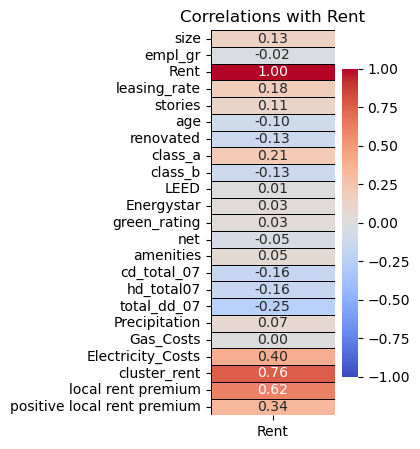

In [21]:
# just correlations with rent
corr_matrix = df.corr()
target_corr = corr_matrix[['Rent']].copy() 
plt.figure(figsize=(2, 5))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f',
            linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.8})
plt.title(f'Correlations with Rent')
plt.show()



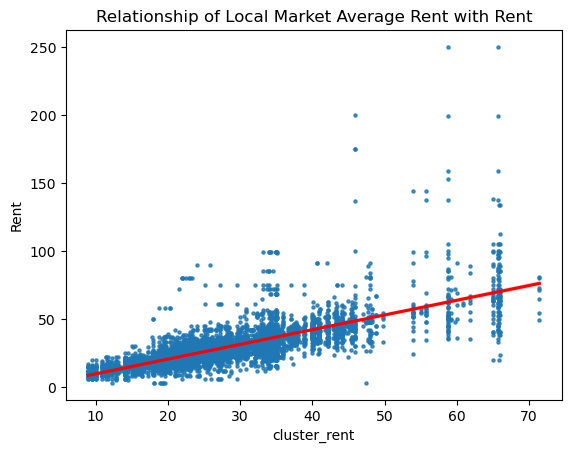

This is what is associated with rent within clusters


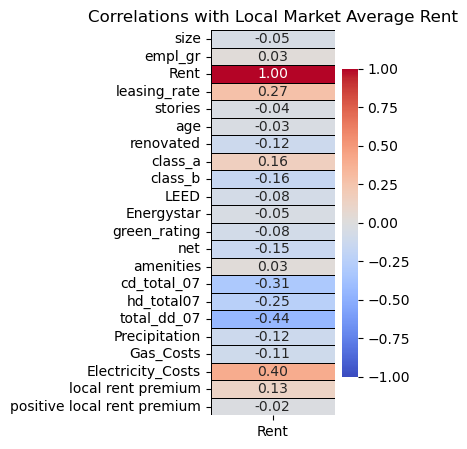

In [23]:
# relationship of cluster rent with rent
sns.regplot(data = df, x = 'cluster_rent', y = 'Rent', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.title('Relationship of Local Market Average Rent with Rent')
plt.show()

# what is associated within clusters with rent
grouped = df.drop(columns = ['cluster_rent']).groupby('cluster').mean()
# just correlations with rent
print('This is what is associated with rent within clusters')
corr_matrix = grouped.corr()
target_corr = corr_matrix[['Rent']].copy() 
plt.figure(figsize=(2, 5))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f',
            linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.8})
plt.title(f'Correlations with Local Market Average Rent')
plt.show()

The first figure displays the correlation of rent with all the other variables in the dataset. The local market average rent (cluster-based rent) is the most strongly correlated with rent (r = 0.76.). As a building's cluster rent increases, then its rent is likely to increase too. This is further illustrated in the scatterplot. Rent appears to be related more to a building's locale than to it's green rating. I broke down how the average cluster features are related to the cluster's average rent in the bottom correlation plot. A cluster's total days using temperature control and electricity costs were the most related to its rent. This is because electricity costs are included in rent, and climate control is a huge contributor to electricity usage. Buildings in the same area experience similar weather, so they are likely to use climate control similarly.

Accordingly, I'm going to remove the effect of locale (added electricity costs due to local weather) on rent by determining the percent difference between each building's rent and cluster rent. I can use this new variable, which I'm calling "local rent premium" to ascertain the relationship of green rating with rent.

## Correlations with New Variable 

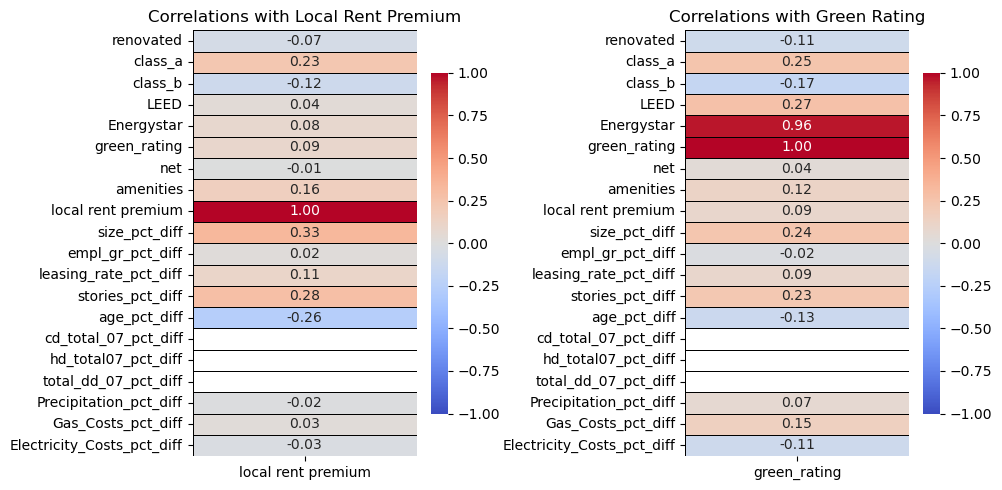

In [19]:
# correlation plots
corr_matrix = df_with_means.corr()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

target_corr_rent = corr_matrix[['local rent premium']].copy()
sns.heatmap(target_corr_rent, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f',
            linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.8}, ax=axes[0])
axes[0].set_title('Correlations with Local Rent Premium')

target_corr_green = corr_matrix[['green_rating']].copy()
sns.heatmap(target_corr_green, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f',
            linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.8}, ax=axes[1])
axes[1].set_title('Correlations with Green Rating')

plt.tight_layout()
plt.show()

The above correlation displays what factors within cluster are related with the local rent premium. All of the numeric features were converted to be relative to the average value for the cluster, and those new features are identified by the suffix "pct_diff." The cooling days, heatings days, and total days of heating and cooling are blank because there is no difference amongst clusters on this feature. Therefore, I was successful in removing the local effect of temperature, climate control, and resulting energy costs on rent. When buildings share the same climate, the purported benefits of a green building, reduced energy costs, are no longer that important, hence the low correlation of electricity costs (r = -0.03). One of the other supposed benefits of being a green building, attracting more tenants, is only slightly related to having a local rent premium (r = 0.11), and green buildings are only slightly more likely to attract more tenants than the cluster average (r = 0.09).

Instead of green ratings, the features that are now popping out as being relatively strongly related to local rent premium are larger size than cluster (r = 0.33), more stories than cluster (r = 0.28), and younger age than cluster (r = -0.26). I can also see that the rent premium commanded by green buildings is actually more likely due to the fact that green buildings are more likely to be larger in size than their cluster (r = .24), have more stories (r = .23), and be younger in age (r = -0.13). 

## Recommendation

After this analysis, my final recommendation is not to pursue a green building. The rent difference identified by your intern didn't account for confounding factors like regional weather. When adjusting for the local rent premium to isolate the impact of regional weather on electricity costs—a major component of rent—green buildings did show a higher local rent premium. However, there were other factors associated with green buildings, aside from it's purported benefits, that actually accounted for increased local rent premium—namely size, stories, and age. Green buildings happened to be larger in size, have more stories, and be younger than their cluster, and this was likely driving most of the rent difference. Therefore, I recommend focusing on constructing a large, multi-story building, which will naturally be newer and command a rent premium, leading to higher revenues.